In [1]:
!pwd

/Users/nico/panoseti/panoseti-software/anomaly-detection


In [2]:
%load_ext autoreload
%autoreload 2

import sys, os
import logging, typing
from torchvision import transforms

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import itertools

import torch
from tqdm import tqdm

sys.path.append('../util')
import panoseti_file_interfaces as pfi
import pff
from vae_model import *
from ph_dataset import *

/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2D1B8D5C-7891-3680-9CF9-F771AE880676> /Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <38796DC6-8F33-3A89-BBAA-5FC71F99817A> /Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
def show_dataset_sample(dataset, nrows=5, ncols=15, cmap='magma', log_cbar=False, norm=False):
    """Preview images from the dataset."""
    nsamples = nrows * ncols
    idxs = np.arange(len(dataset))
    sample_idxs = np.random.choice(idxs, nsamples, replace=False)
    
    if len(sample_idxs) < nsamples:
        print('Not enough training data')

    f = plt.figure(figsize=(ncols, nrows))
    # f.tight_layout()

    canvas = np.zeros((nrows * 16, ncols * 16))
    xy_indices = itertools.product(range(nrows), range(ncols))
    for i, (row, col) in enumerate(xy_indices):
        idx = sample_idxs[i]
        canvas[row*16:(row+1)*16, col*16:(col+1)*16] = ph_dataset.get_ph_data(idx)['img']
    if norm:
        canvas = ph_dataset.norm(canvas)
    if log_cbar:
        img_plt = plt.imshow(canvas, cmap=cmap)
        # format cbar
        cbar = plt.colorbar(img_plt, fraction=0.027, pad=0.025)
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(colorbar_formatter))
        plt.title("Log-Normalized Real Pulse Height Images")
    else:
        img_plt = plt.imshow(canvas, cmap=cmap)
        # format cbar
        cbar = plt.colorbar(img_plt, fraction=0.027, pad=0.025)
        plt.title("Real Pulse Height Images")
    plt.show(f)

In [87]:
ph_dataset_config = {
    "max_ph_frames": 10_000,
    "observing_runs": [
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2023-07-14T04:46:21Z.runtype_sci-obs.pffd',
            "module_ids": 'all',
        },
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2023-08-15T07:15:50Z.runtype_sci-obs.pffd',
            "module_ids": 'all',
        },
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2023-09-14T04:25:43Z.runtype_sci-obs.pffd',
            "module_ids": 'all',
        },
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2023-10-12T04:28:34Z.runtype_eng-test.pffd',
            "module_ids": 'all',
        },
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2024-05-24T04:37:30Z.runtype_sci-data.pffd',
            "module_ids": 'all',
        },
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2024-07-25T04:34:06Z.runtype_sci-data.pffd',
            "module_ids": 'all',
        },
    ]
}

In [95]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ConvertImageDtype(torch.float),
])

ph_dataset = PulseHeightDataset(ph_dataset_config, transform=transform, log_level=logging.ERROR)
ph_dataset.reset_ph_generator()

Computing PH baselines for obs_Lick.start_2023-07-14T04:46:21Z.runtype_sci-obs.pffd


100%|███████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:00<00:00, 14046.87frames/s]


Computing PH baselines for obs_Lick.start_2023-08-15T07:15:50Z.runtype_sci-obs.pffd


100%|███████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:00<00:00, 14026.14frames/s]


Computing PH baselines for obs_Lick.start_2023-09-14T04:25:43Z.runtype_sci-obs.pffd


100%|███████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:00<00:00, 14301.12frames/s]


Computing PH baselines for obs_Lick.start_2023-10-12T04:28:34Z.runtype_eng-test.pffd


100%|███████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:00<00:00, 14300.18frames/s]


Computing PH baselines for obs_Lick.start_2024-05-24T04:37:30Z.runtype_sci-data.pffd


100%|███████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:00<00:00, 14133.25frames/s]


Computing PH baselines for obs_Lick.start_2024-07-25T04:34:06Z.runtype_sci-data.pffd


100%|███████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:00<00:00, 13640.36frames/s]


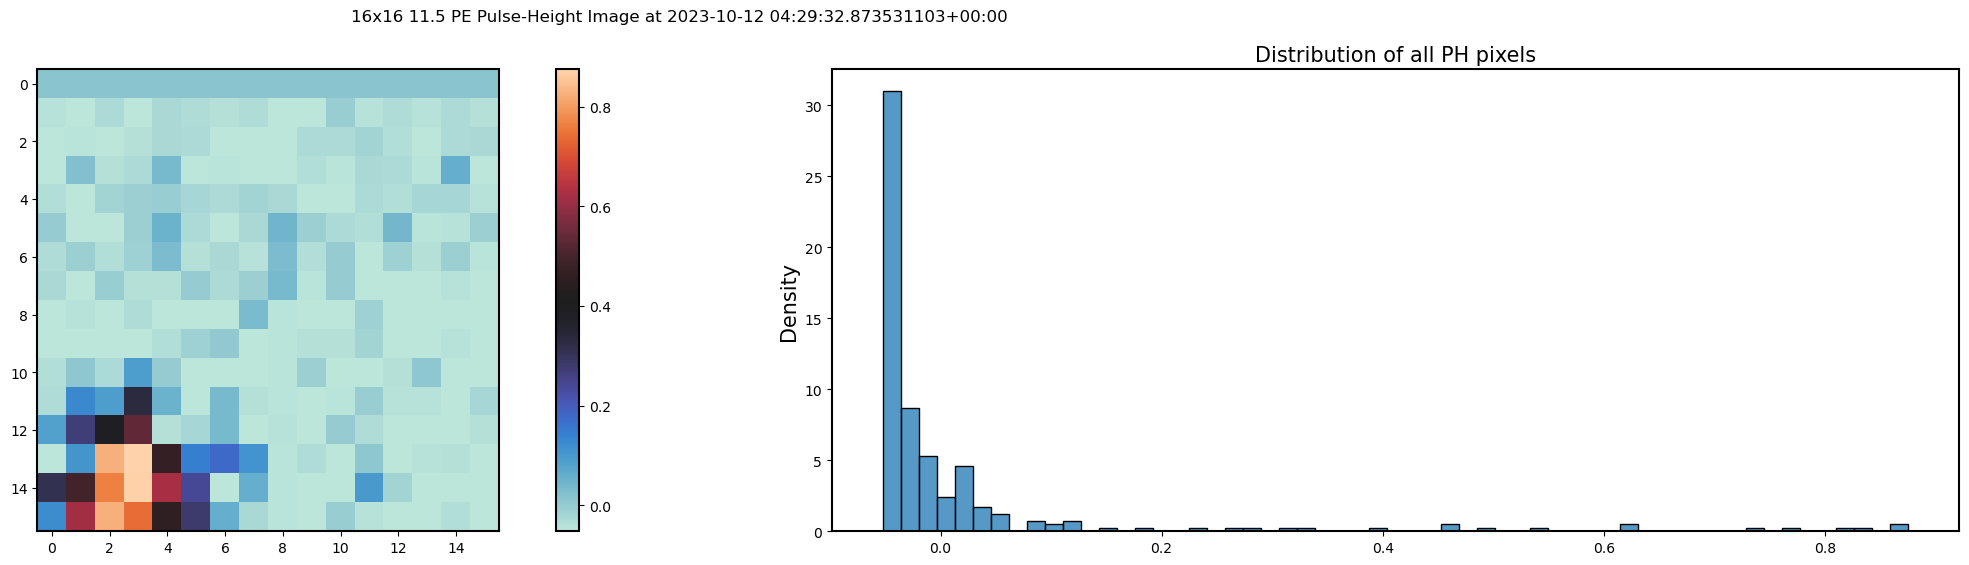

In [96]:
# PH data EDA: visualize PH image and the distribution of pixel values.
# ph_dataset.reset_ph_generator()
ph_data = ph_dataset.get_ph_data(2)

assert ph_data['img'] is not None
f, axs = plt.subplots(1, 2, figsize=(8 * 4, 6))
ph_dataset.plot_ph_img(ph_data['img'], ph_data['meta'], ax=axs[0])
ph_dataset.plot_ph_pixel_dist(ph_data['img'],  ph_data['meta'], ax=axs[1], upper=None)
# ph_dataset.plot_ph_pixel_dist(ph_data['img'],  ph_data['meta'], ax=axs[2], upper=False)
# ph_dataset.plot_ph_pixel_dist(ph_data['img'],  ph_data['meta'], ax=axs[3], upper=True)
f.suptitle(f"16x16 11.5 PE Pulse-Height Image at {ph_data['meta']['unix_timestamp']}")
plt.show()

In [97]:
ph_data['meta']

{'quabo_num': 2,
 'pkt_num': 57595,
 'pkt_tai': 593,
 'pkt_nsec': 873531188,
 'tv_sec': 1697084972,
 'tv_usec': 877644,
 'wr_timestamp (s)': Decimal('1697084972.873531188'),
 'unix_timestamp': Timestamp('2023-10-12 04:29:32.873531103+0000', tz='UTC')}

In [98]:
ph_dataset.EFFECTIVE_MAX_VAL

16383.75

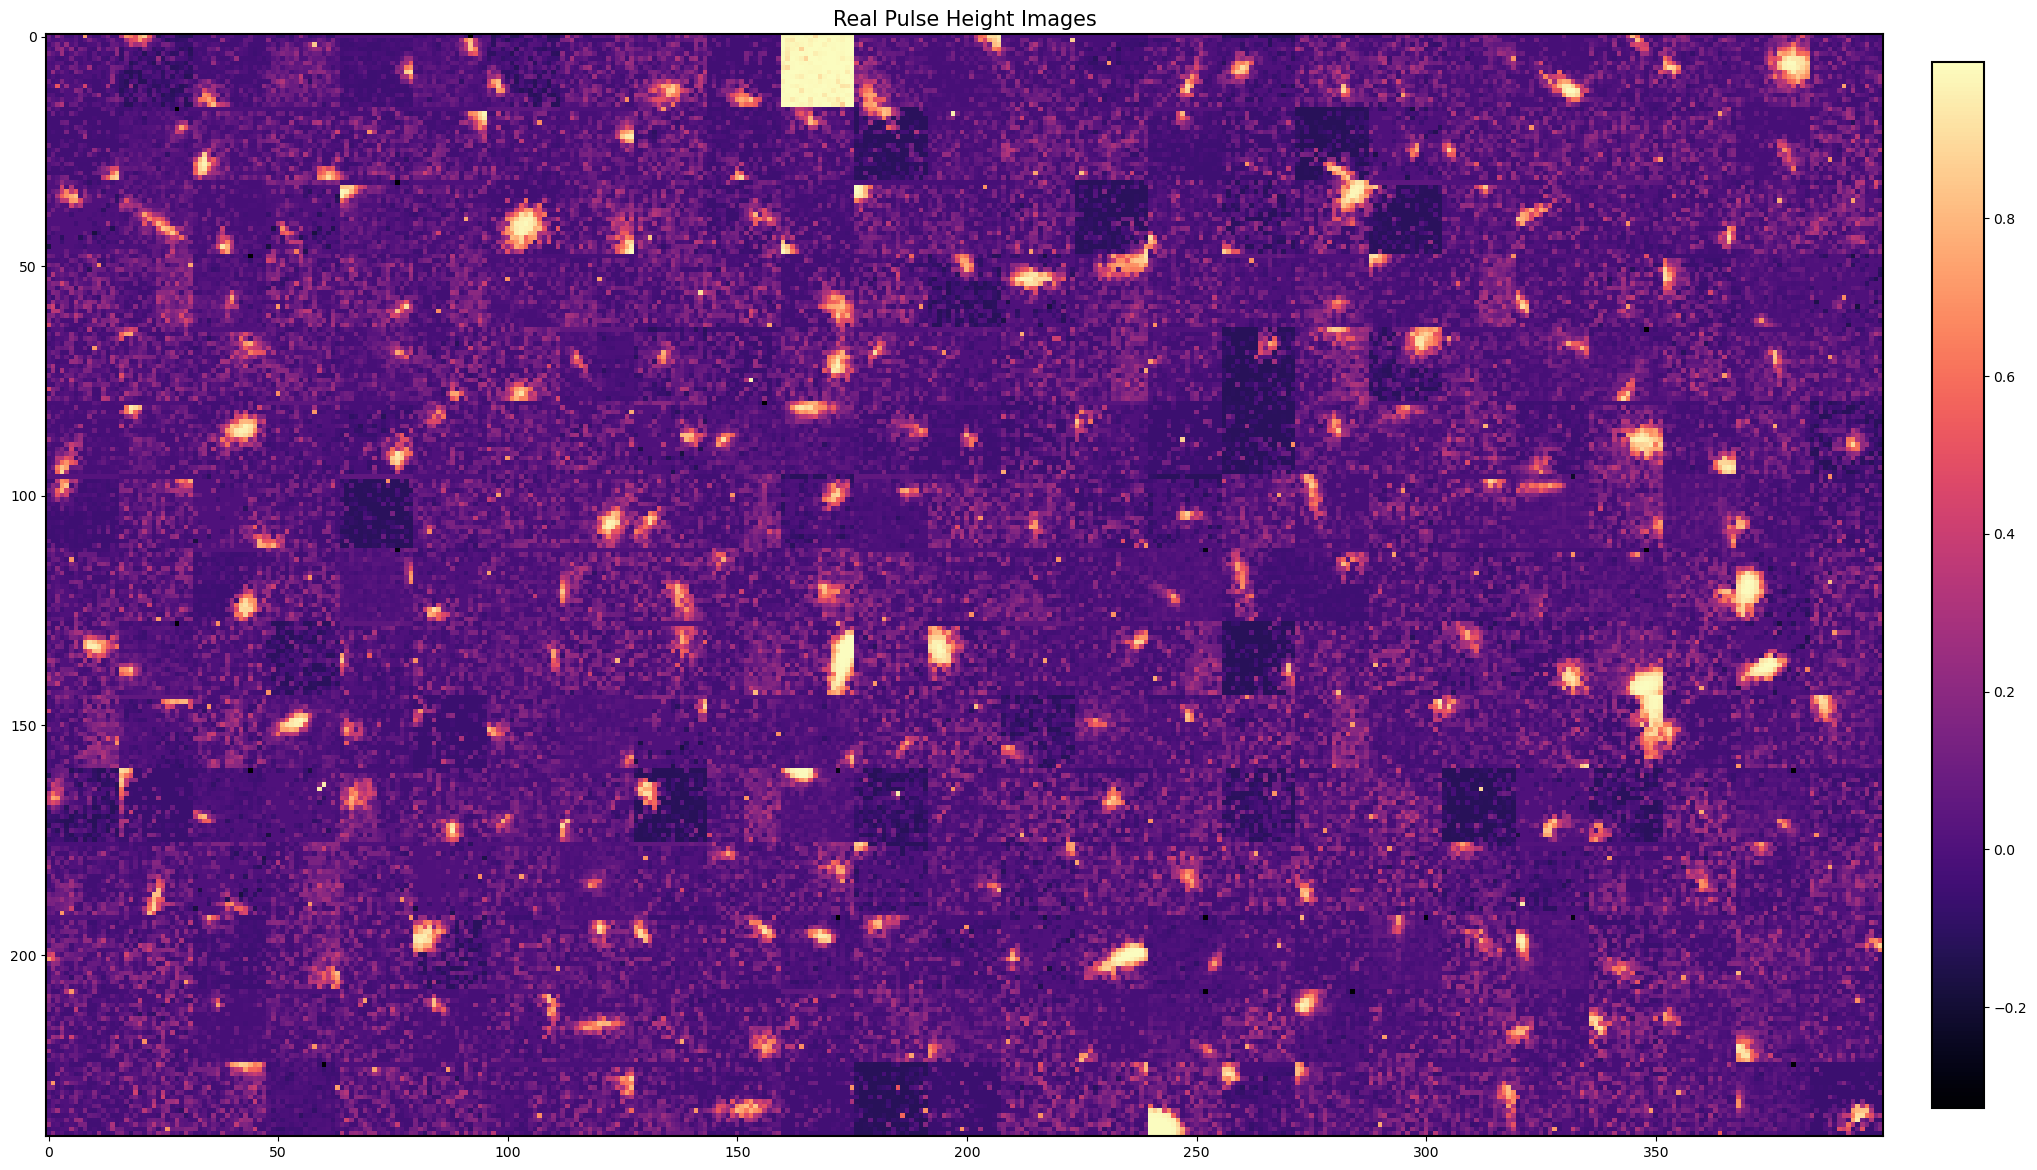

In [99]:
show_dataset_sample(ph_dataset, nrows=15, ncols=25, norm=True)